In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from flows import MaskingDense, IAF, MAF
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
latent_dim = 64
training_steps = 2
batch_size = 64

learning_rate = 0.0005

num_flow = 7

dataset_path = r"C:\Users\i9233\recommend system\dataset\hetrec2011-lastfm-2k"

准备输入的数据，数据的来源见 dataset解读.和之前单独训练不同，这里同时需要user和item作为输入

In [5]:
user_representation_normalized = pd.read_csv(dataset_path + "\\user_representation_sigmoid.csv" )
item_representation = pd.read_csv(dataset_path + "\\item_representation_1.csv" )

dataset_len = user_representation_normalized.shape[0]
id_list = np.arange(dataset_len) # 这里的类型是int32
user_data = tf.data.Dataset.from_tensor_slices((tf.cast(user_representation_normalized.values, 'float32'), id_list))

user_data = user_data.repeat().batch(batch_size).prefetch(1)

dataset_len = item_representation.shape[0]
id_list = np.arange(dataset_len) # 这里的类型是int32
item_data = tf.data.Dataset.from_tensor_slices((tf.cast(item_representation.values, 'float32'), id_list))

item_data = item_data.repeat().batch(batch_size).prefetch(1)

这里是准备标签，标签是训练的时候决定的

In [6]:
user_tag = pd.read_table(dataset_path + "\\user_taggedartists.dat")
user_original_id = user_tag.drop_duplicates(subset='userID', keep='first', inplace=False).reset_index(drop=True)
item_original_id = user_tag.drop_duplicates(subset='artistID', keep='first', inplace=False).reset_index(drop=True)

user_artists = pd.read_table(dataset_path + "\\user_artists.dat")
user_artists_grouped = user_artists.groupby('userID').groups

In [7]:
def get_y_true(x_id, y_id, batch_size):
    label = np.zeros(shape=(batch_size, batch_size))
    for x in x_id.numpy():
        origin_user_id = user_original_id.iloc[x]['userID']
    
        for y in y_id.numpy():
            origin_item_id = item_original_id.iloc[y]['artistID']
        
            # 找到这个user是否有订阅这个item
            if origin_item_id in user_artists_grouped[origin_user_id].values:
                label[x%batch_size][y%batch_size] = 1
    # label[x][y] 表示 user x 对 y 的兴趣程度。每次输入都是一个batch，所以label取余就可以得到正确的xy坐标
    return label.astype(np.float32)

In [8]:
class RS(tf.keras.Model):
    def __init__(self, input_size, output_size=256, num_nn=4):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_nn = num_nn
        
        self.dense = []
        for i in range(self.num_nn):
            self.dense.append(Dense(units=self.output_size, activation=tf.nn.leaky_relu))
            
        self.out = Dense(units=self.output_size, activation=tf.nn.leaky_relu)
        self.act = tf.nn.sigmoid
        # 因为weighted_cross_entropy_with_logits里面会有sigmoid
        self.matrics = tf.nn.weighted_cross_entropy_with_logits
        # self.matrics = tf.keras.metrics.binary_crossentropy
    
    @tf.function
    def call(self, inputs): 
        # inputs is [batch_size, 2latent_dim], outputs is [batch_size, batch_size]
        for i in range(self.num_nn):
            inputs = self.dense[i](inputs)
            
        outputs = self.out(inputs)
        
        return outputs
    
    @tf.function
    def act(self, inputs): 
        self.act(inputs)
        return self.act(inputs)
    
    @tf.function
    def RSloss(self, y_true, y_pred):
        y_pred = tf.keras.backend.flatten(y_pred)
        y_true = tf.keras.backend.flatten(y_true)
        # loss = tf.keras.metrics.binary_crossentropy(y_true, y_pred)
        # 要提高召回率，即降低将1预测0的概率，提高将1预测成1的概率。pos_weight > 1
        loss = self.matrics(labels=y_true,logits=y_pred, pos_weight=5)
        
        return tf.math.reduce_mean(loss)

装入之前用CAF训练好的IAF模型，有user和item两个

In [9]:
training_steps = 20000
place = "./sigmoid_BinaryCrossentropy_%d_%d_%d_%d/user/iaf/" % (latent_dim, training_steps, batch_size, num_flow)
user_inference = tf.saved_model.load(place)
place = "./sigmoid_BinaryCrossentropy_%d_%d_%d_%d/item/iaf/" % (latent_dim, training_steps, batch_size, num_flow)
item_inference = tf.saved_model.load(place)

In [10]:
num_nn = 5
rs = RS(input_size=latent_dim*2, output_size=batch_size, num_nn=num_nn)

In [33]:
learning_rate = 0.0001
training_steps = 500
display_step = 50
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

step: 0, loss: 2889.604004
step: 50, loss: 19.765724
step: 100, loss: 19.939590
step: 150, loss: 370.007202
step: 200, loss: 31.866163
step: 250, loss: 18.407688
step: 300, loss: 422.295990
step: 350, loss: 24.084173
step: 400, loss: 16.551092
step: 450, loss: 8.380188
step: 500, loss: 16.665154


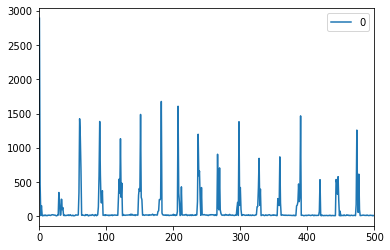

In [34]:
a = enumerate(user_data.take(training_steps + 1))
b = enumerate(item_data.take(training_steps + 1))
loss_list = []
for ((step, i), (step,j)) in zip(a, b):
    with tf.GradientTape() as g:
        (user, x_id) = i
        (item, y_id) = j
    
        user, e_0, _z_log_sigma_0, _z_sigmas = user_inference.inference(user)
        item, e_0, _z_log_sigma_0, _z_sigmas = item_inference.inference(item)
    
        # 经过一番折腾得到最终的表示，batch_size * latent_dim，再叠起来得到 batch_size * 2latent_dim
        conbine = tf.keras.backend.concatenate((user, item), axis=1)
    
        # 输出是 batch_size * batch_size
        y_pred = rs.call(conbine)
        y_pred_sigmoid = rs.act(y_pred)
        
        y_true = get_y_true(x_id, y_id, batch_size)
    
        loss = rs.RSloss(y_true, y_pred)
        
        loss = loss*batch_size*batch_size
        loss_list.append(loss)
        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
            
    gradients = g.gradient(loss, rs.variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, rs.variables))
    
p = pd.DataFrame(loss_list)
p.plot()

真实数据太稀疏了，否则训练的label全是0

1. 数据增强，将正向的数据反复进行训练
2. 加强权重。weighted_cross_entropy_with_logits

训练好了再用其他方法来检测推荐准确度。

数据集中有联系的，基本上应该都能预测出来，但是没有的，也会预测出来，这里就涉及到了真假阳性的问题了，应该和训练时间也有关系，过拟合了就肯定有问题。

In [36]:
place = "./rs/%d_%d_%d_%d_%d/" % (num_nn, training_steps, latent_dim, batch_size, num_flow)
tf.saved_model.save(rs, place)

INFO:tensorflow:Assets written to: ./rs/5_500_64_64_7/assets


In [37]:
def evaluate(rs_model, training_steps, TP, FP, TN, FN, user_data, item_data, threshold=0.0001):
    a = enumerate(user_data.take(training_steps))
    b = enumerate(item_data.take(training_steps))
    for ((step, i), (step,j)) in zip(a, b):
        (user, x_id) = i
        (item, y_id) = j
        user, e_0, _z_log_sigma_0, _z_sigmas = user_inference.inference(user)
        item, e_0, _z_log_sigma_0, _z_sigmas = item_inference.inference(item)
        conbine = tf.keras.backend.concatenate((user, item), axis=1)
        
        # 输出是 batch_size * batch_size
        y_pred = rs_model.call(conbine)
        y_pred_sigmoid = rs_model.act(y_pred)
        
        y_true = get_y_true(x_id, y_id, batch_size)
    
        XP = y_true[y_pred_sigmoid>=threshold]  # 预测出来是 positive 的数量
        XN = y_true[y_pred_sigmoid<threshold]  # 预测出来是 negative 的数量
    
        TP += np.sum(XP) # 预测出来是positive，实际上是true的数量
        FP += XP.shape[0] - np.sum(XP)
        TN += np.sum(XN)
        FN += XN.shape[0] - np.sum(XN)
    
    return TP, FP, TN, FN

In [32]:
threshold = 0.0001
training_steps = 5

TP = FP = TN = FN = 0

In [38]:
TP, FP, TN, FN = evaluate(rs, training_steps, TP, FP, TN, FN, user_data, item_data, threshold=0.0001)

Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1 = 2*Precision*Recall/ (Precision+Recall)
print("Precision:%f, Recall:%f, F1:%f" %(Precision, Recall, F1))
print("TP:%f, FP:%f, FN:%f, TN:%f。    参考，前三大，TN小"%(TP, FP, FN, TN))

Precision:0.000512, Recall:0.002150, F1:0.000827
TP:1703.000000, FP:3324088.000000, FN:790213.000000, TN:476.000000。    参考，前三大，TN小


a>=threshold 的都是检测出来positive，y_true==1 的都是true。

但是按照推荐系统的理念，P应该要更多才符合标准，即 FP 大，TP 大。反之，不能将别人认为感兴趣的标成N，即TN要小。同理，FN要大，将别人不感兴趣的标成不感兴趣的，但是实际上这个往往是最大的。

FP就是需要推荐的内容。